# The libraries, game enviroment.
The following libraries are requried to the run the Training and plotting of results from prviously trainned models.
OpenAI gym has to be installed on a CUDA enabled system to train new models. Gym has to be installed with ATARI library in order to access the Pong game.
please follow the instruction at https://gym.openai.com

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
import math
import random
import matplotlib
from collections import namedtuple
from itertools import count
from PIL import Image
import torchvision.transforms as T
import pickle
import cv2
from torch.autograd import Variable

np.random.seed(42)
torch.manual_seed(42)

game='PongNoFrameskip-v4'
env = gym.make(game)

ModuleNotFoundError: No module named 'gym'

# Choose if you use Double DQN or Dueling DQN or both. Also choose the number of frames you will stack.

The options for making a new model as defined in the report. 

In [0]:
Double='on'
Duel='off'
num_scr=4

if (Double=='on') and (Duel=='on'):
    DQNname='Double Duel DQN'
elif (Double=='off') and (Duel=='on'):
    DQNname='Duel DQN'
elif (Double=='on') and (Duel=='off'):
    DQNname='Double DQN'
else:
    DQNname='normal DQN'

# Replay memory, DQN model

In [0]:
# Run environment
env.reset()  # Reset environment

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, n, h, w, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(n, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU() )

        conv_out_size = self._get_conv_out(n,h,w)
        
        if Duel=='off':
            # Normal DQN
            self.fc = nn.Sequential(
                nn.Linear(conv_out_size, 512),
                nn.ReLU(),
                nn.Linear(512, n_actions)  )
        else:            
            # Duel network
            self.value = nn.Sequential(
                nn.Linear(conv_out_size, 512),
                nn.ReLU(),
                nn.Linear(512, 1)  )
            self.advantage = nn.Sequential(
                nn.Linear(conv_out_size, 512),
                nn.ReLU(),
                nn.Linear(512, n_actions) )
    def _get_conv_out(self, n,h,w):
        o = self.conv(Variable(torch.zeros(1,n,h,w)))# (1,*[4,84,84])=(1,4,84,84)
        return int(np.prod(o.size()))# product of all elements

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        if Duel=='off':
            # Normal DQN
            output = self.fc(conv_out)
        else:
            # Duel network
            adv = self.advantage(conv_out)
            val = self.value(conv_out).expand(-1,adv.size(1))
            output = val + adv - adv.mean(1, keepdim=True).expand(-1, adv.size(1))
        return output

# Edit screen (frame)

In [0]:
resize = T.Compose([T.ToPILImage(), T.Resize(84, interpolation=Image.CUBIC), T.ToTensor()])

# now it is GRAY scale
def get_screen():
    screen = env.render(mode='rgb_array')
    screen =  cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
    screen = screen[34:194,:]
    screen = np.ascontiguousarray(sc
                                  een, dtype=np.float32) / 255
    screen = torch.from_numpy(screen).unsqueeze(0)
    return resize(screen).unsqueeze(0)

# Hyper parameters

In [0]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.02
EPS_DECAY = 2*10**4
MEMORY_BOUND = 10000
TARGET_UPDATE = 1000

# Network and optimizer

In [0]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(num_scr ,screen_height, screen_width, n_actions)
target_net = DQN(num_scr, screen_height, screen_width, n_actions)
## Loding previopus data of policy_net

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

if use_cuda:
    policy_net.cuda()
    target_net.cuda()
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.RMSprop(policy_net.parameters(),lr=0.0001)
memory = ReplayMemory(100000)

# User defined funtion for back propagation 

In [0]:
def optimize_model():
    if len(memory) < MEMORY_BOUND:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = get_variable(torch.zeros(BATCH_SIZE))
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    if Double=='off':
        # Normal DQN
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    else:
        # Double DQN
        ad = policy_net(non_final_next_states).max(1)[1].view(-1,1).detach()
        qbar=get_variable(torch.zeros(BATCH_SIZE))
        qbar[non_final_mask]=target_net(non_final_next_states).gather(1, ad).view(-1).detach()
        expected_state_action_values = ( qbar*GAMMA ) + reward_batch

    loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# User defined function for training

In [6]:
# moving average for plotting
def movave(r,n=10):
    X=[i for i in range(len(r))]
    for i in range(len(r)):
        if i+1<n:
            X[i]=sum(r[:i+1])/(i+1)
        else:
            X[i]=sum(r[i+1-n:i+1])/n
    return X

# traning
durations = []
R=[]
frames=[]
T=0
steps_done=0
def train(num_episodes):
    global R
    global durations
    global T
    global frames
    global steps_done
    global eps_threshold
    #fig, ax = plt.subplots()
    for i_episode in range(num_episodes):
        print('episode',len(durations))
        # Initialize the environment and state
        env.reset()
        s = [i for i in range(num_scr)]
        a = [i for i in range(num_scr-1)]
        d = [False for i in range(num_scr-1)]
        for i in range(num_scr-1):
            s[i]=get_screen()
            a[i]=get_variable(torch.tensor([[random.randrange(n_actions)]], dtype=torch.long))
            _,_,d[i],_=env.step(a[i].item())
        s[num_scr-1]=get_screen()
        state =get_variable( Variable(torch.cat([s[i].squeeze(0) for i in range(num_scr)]).unsqueeze(0)))
        Reward=0.0

        T=T+num_scr
        if sum(d)!=0:
            durations.append(0)
            R.append(Reward)
            frames.append(T)
        else:
            for t in count():
                # Select and perform an action
                
                #action = select_action(state)
                sample = random.random()
                eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
                if t % STEPS ==0:
                    steps_done +=1
                if sample > eps_threshold:
                    with torch.no_grad():
                        action = get_variable(policy_net(state).max(1)[1].view(1, 1))
                else:
                    action = get_variable(torch.tensor([[random.randrange(n_actions)]], dtype=torch.long))
                
                # states update
                reward_cpu = 0.0
                ss=[i for i in range(num_scr)]
                dd=[False for i in range(num_scr)]
                for i in range(num_scr):
                    _, re, dd[i], _ =env.step(action.item())
                    T+=1
                    reward_cpu = reward_cpu + re 
                    ss[i]=get_screen()
                    if dd[i]: break
                # frames update
                reward = get_variable(torch.tensor([reward_cpu]))
                if t % 100 == 0:
                    print('t=',t,'/ Frames',T,'/ steps_done',steps_done,'/ eps',eps_threshold)
                # Observe new state
                if sum(dd)==0:
                    next_state = get_variable(torch.cat([ss[i].squeeze(0) for i in range(num_scr)]).unsqueeze(0))
                else:
                    next_state = None
            # Store the transition in memory
                memory.push(state, action, next_state, reward)
            # Move to the next state
                state = Variable(next_state)
                Reward = Reward+reward_cpu
            # Perform one step of the optimization (on the target network)
                if t % STEPS == 0:
                    optimize_model()
                if sum(dd)!=0:
                    durations.append(num_scr*(t+1)+num_scr)
                    R.append(Reward)
                    frames.append(T)
                    break
#              Update the target network, copying all weights and biases in DQN
                if T % TARGET_UPDATE == 0:
                    target_net.load_state_dict(policy_net.state_dict())
        plt.figure()
        plt.plot(frames,R)
        plt.plot(frames,movave(R))
        plt.xlabel('Frames')
        plt.ylabel('Rewards')
        plt.title(DQNname)
        plt.show()
              
    print('Complete')



if game=='PongNoFrameskip-v4':
    difficulty='easy'
elif game=='PongNoFrameskip-v0':
    difficulty='difficult'
else:
    difficulty='other game'

NameError: name 'game' is not defined

if you saved a model and you want to continue training with the sved model, run the code below:

In [0]:
with open('data.pickle', 'rb') as f:
  policy,target,T,frames,durations,R,steps_done,difficulty,STEPS = pickle.load(f)
policy_net.load_state_dict(policy)
target_net.load_state_dict(target)

<All keys matched successfully>

# Training and saving the model

episode 100
t= 0 / Frames 621957 / steps_done 310904 / eps 0.020000173801375944
t= 100 / Frames 622157 / steps_done 311004 / eps 0.020000172934537968
t= 200 / Frames 622357 / steps_done 311104 / eps 0.02000017207202336
t= 300 / Frames 622557 / steps_done 311204 / eps 0.020000171213810564
t= 400 / Frames 622757 / steps_done 311304 / eps 0.02000017035987812
t= 500 / Frames 622957 / steps_done 311404 / eps 0.020000169510204682
t= 600 / Frames 623157 / steps_done 311504 / eps 0.02000016866476901
t= 700 / Frames 623357 / steps_done 311604 / eps 0.020000167823549967
t= 800 / Frames 623557 / steps_done 311704 / eps 0.02000016698652652
t= 900 / Frames 623757 / steps_done 311804 / eps 0.020000166153677744
t= 1000 / Frames 623957 / steps_done 311904 / eps 0.02000016532498282
t= 1100 / Frames 624157 / steps_done 312004 / eps 0.020000164500421025
t= 1200 / Frames 624357 / steps_done 312104 / eps 0.020000163679971754
t= 1300 / Frames 624557 / steps_done 312204 / eps 0.020000162863614487
t= 1400 / F

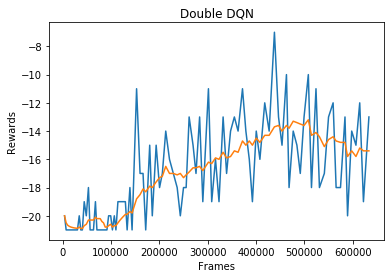

episode 101
t= 0 / Frames 633265 / steps_done 316557 / eps 0.020000131008620928
t= 100 / Frames 633465 / steps_done 316657 / eps 0.020000130355212704
t= 200 / Frames 633665 / steps_done 316757 / eps 0.020000129705063367
t= 300 / Frames 633865 / steps_done 316857 / eps 0.020000129058156665
t= 400 / Frames 634065 / steps_done 316957 / eps 0.020000128414476424
t= 500 / Frames 634265 / steps_done 317057 / eps 0.02000012777400655
t= 600 / Frames 634465 / steps_done 317157 / eps 0.020000127136731036
t= 700 / Frames 634665 / steps_done 317257 / eps 0.02000012650263394
t= 800 / Frames 634865 / steps_done 317357 / eps 0.020000125871699425
t= 900 / Frames 635065 / steps_done 317457 / eps 0.020000125243911704
t= 1000 / Frames 635265 / steps_done 317557 / eps 0.02000012461925509
t= 1100 / Frames 635465 / steps_done 317657 / eps 0.02000012399771396
t= 1200 / Frames 635665 / steps_done 317757 / eps 0.02000012337927278
t= 1300 / Frames 635865 / steps_done 317857 / eps 0.020000122763916092
t= 1400 / F

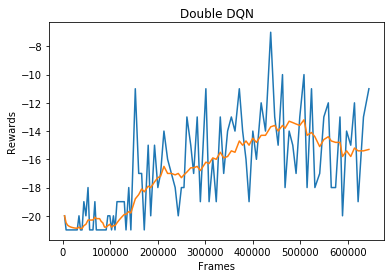

episode 102
t= 0 / Frames 644697 / steps_done 322272 / eps 0.020000098446487813
t= 100 / Frames 644897 / steps_done 322372 / eps 0.02000009795548391
t= 200 / Frames 645097 / steps_done 322472 / eps 0.020000097466928893
t= 300 / Frames 645297 / steps_done 322572 / eps 0.020000096980810556
t= 400 / Frames 645497 / steps_done 322672 / eps 0.02000009649711675
t= 500 / Frames 645697 / steps_done 322772 / eps 0.02000009601583537
t= 600 / Frames 645897 / steps_done 322872 / eps 0.020000095536954393
t= 700 / Frames 646097 / steps_done 322972 / eps 0.020000095060461846
t= 800 / Frames 646297 / steps_done 323072 / eps 0.020000094586345815
t= 900 / Frames 646497 / steps_done 323172 / eps 0.020000094114594445
t= 1000 / Frames 646697 / steps_done 323272 / eps 0.02000009364519595
t= 1100 / Frames 646897 / steps_done 323372 / eps 0.020000093178138584
t= 1200 / Frames 647097 / steps_done 323472 / eps 0.02000009271341068
t= 1300 / Frames 647297 / steps_done 323572 / eps 0.020000092251000613
t= 1400 / F

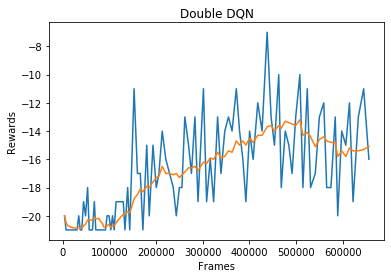

episode 103
t= 0 / Frames 655932 / steps_done 327889 / eps 0.02000007434103815
t= 100 / Frames 656132 / steps_done 327989 / eps 0.020000073970260674
t= 200 / Frames 656332 / steps_done 328089 / eps 0.02000007360133246
t= 300 / Frames 656532 / steps_done 328189 / eps 0.02000007323424428
t= 400 / Frames 656732 / steps_done 328289 / eps 0.020000072868986966
t= 500 / Frames 656932 / steps_done 328389 / eps 0.020000072505551376
t= 600 / Frames 657132 / steps_done 328489 / eps 0.02000007214392843
t= 700 / Frames 657332 / steps_done 328589 / eps 0.020000071784109084
t= 800 / Frames 657532 / steps_done 328689 / eps 0.02000007142608435
t= 900 / Frames 657732 / steps_done 328789 / eps 0.020000071069845266
t= 1000 / Frames 657932 / steps_done 328889 / eps 0.020000070715382935
t= 1100 / Frames 658132 / steps_done 328989 / eps 0.020000070362688492
t= 1200 / Frames 658332 / steps_done 329089 / eps 0.020000070011753118
t= 1300 / Frames 658532 / steps_done 329189 / eps 0.02000006966256804
t= 1400 / Fr

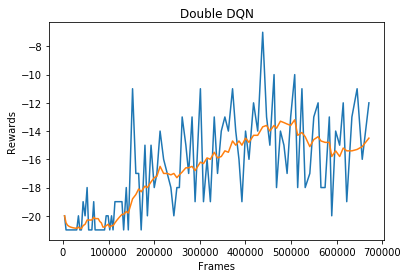

episode 104
t= 0 / Frames 670533 / steps_done 335189 / eps 0.020000051607299705
t= 100 / Frames 670733 / steps_done 335289 / eps 0.020000051349907223
t= 200 / Frames 670933 / steps_done 335389 / eps 0.020000051093798495
t= 300 / Frames 671133 / steps_done 335489 / eps 0.02000005083896711
t= 400 / Frames 671333 / steps_done 335589 / eps 0.020000050585406704
t= 500 / Frames 671533 / steps_done 335689 / eps 0.020000050333110937
t= 600 / Frames 671733 / steps_done 335789 / eps 0.020000050082073496
t= 700 / Frames 671933 / steps_done 335889 / eps 0.020000049832288112
t= 800 / Frames 672133 / steps_done 335989 / eps 0.02000004958374854
t= 900 / Frames 672333 / steps_done 336089 / eps 0.020000049336448562
t= 1000 / Frames 672533 / steps_done 336189 / eps 0.020000049090382
t= 1100 / Frames 672733 / steps_done 336289 / eps 0.020000048845542698
t= 1200 / Frames 672933 / steps_done 336389 / eps 0.020000048601924537
t= 1300 / Frames 673133 / steps_done 336489 / eps 0.020000048359521426
t= 1400 / F

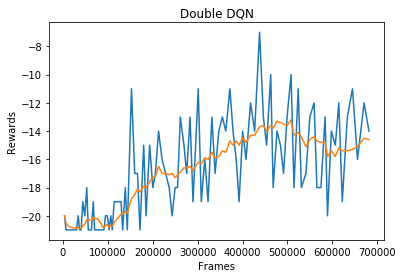

episode 105
t= 0 / Frames 681284 / steps_done 340564 / eps 0.020000039445230086
t= 100 / Frames 681484 / steps_done 340664 / eps 0.020000039248496183
t= 200 / Frames 681684 / steps_done 340764 / eps 0.02000003905274349
t= 300 / Frames 681884 / steps_done 340864 / eps 0.02000003885796712
t= 400 / Frames 682084 / steps_done 340964 / eps 0.0200000386641622
t= 500 / Frames 682284 / steps_done 341064 / eps 0.020000038471323887
t= 600 / Frames 682484 / steps_done 341164 / eps 0.02000003827944736
t= 700 / Frames 682684 / steps_done 341264 / eps 0.020000038088527818
t= 800 / Frames 682884 / steps_done 341364 / eps 0.02000003789856049
t= 900 / Frames 683084 / steps_done 341464 / eps 0.020000037709540633
t= 1000 / Frames 683284 / steps_done 341564 / eps 0.020000037521463516
t= 1100 / Frames 683484 / steps_done 341664 / eps 0.020000037334324434
t= 1200 / Frames 683684 / steps_done 341764 / eps 0.020000037148118713
t= 1300 / Frames 683884 / steps_done 341864 / eps 0.0200000369628417
t= 1400 / Fram

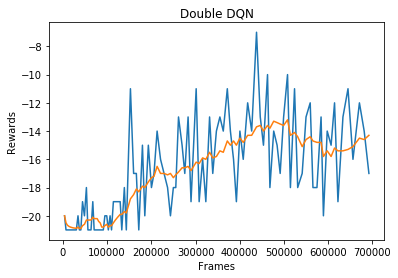

episode 106
t= 0 / Frames 691985 / steps_done 345914 / eps 0.020000030187053174
t= 100 / Frames 692185 / steps_done 346014 / eps 0.02000003003649462
t= 200 / Frames 692385 / steps_done 346114 / eps 0.020000029886686976
t= 300 / Frames 692585 / steps_done 346214 / eps 0.020000029737626504
t= 400 / Frames 692785 / steps_done 346314 / eps 0.020000029589309472
t= 500 / Frames 692985 / steps_done 346414 / eps 0.020000029441732178
t= 600 / Frames 693185 / steps_done 346514 / eps 0.020000029294890923
t= 700 / Frames 693385 / steps_done 346614 / eps 0.020000029148782048
t= 800 / Frames 693585 / steps_done 346714 / eps 0.02000002900340189
t= 900 / Frames 693785 / steps_done 346814 / eps 0.02000002885874682
t= 1000 / Frames 693985 / steps_done 346914 / eps 0.02000002871481322
t= 1100 / Frames 694185 / steps_done 347014 / eps 0.02000002857159749
t= 1200 / Frames 694385 / steps_done 347114 / eps 0.020000028429096053
t= 1300 / Frames 694585 / steps_done 347214 / eps 0.020000028287305346
t= 1400 / F

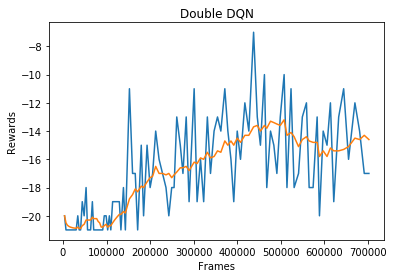

episode 107
t= 0 / Frames 702673 / steps_done 351257 / eps 0.02000002310994697
t= 100 / Frames 702873 / steps_done 351357 / eps 0.020000022994685628
t= 200 / Frames 703073 / steps_done 351457 / eps 0.020000022879999156
t= 300 / Frames 703273 / steps_done 351557 / eps 0.020000022765884685
t= 400 / Frames 703473 / steps_done 351657 / eps 0.020000022652339362
t= 500 / Frames 703673 / steps_done 351757 / eps 0.020000022539360347
t= 600 / Frames 703873 / steps_done 351857 / eps 0.02000002242694482
t= 700 / Frames 704073 / steps_done 351957 / eps 0.020000022315089964
t= 800 / Frames 704273 / steps_done 352057 / eps 0.02000002220379299
t= 900 / Frames 704473 / steps_done 352157 / eps 0.02000002209305111
t= 1000 / Frames 704673 / steps_done 352257 / eps 0.020000021982861556
t= 1100 / Frames 704873 / steps_done 352357 / eps 0.020000021873221578
t= 1200 / Frames 705073 / steps_done 352457 / eps 0.02000002176412843
t= 1300 / Frames 705273 / steps_done 352557 / eps 0.020000021655579386
t= 1400 / F

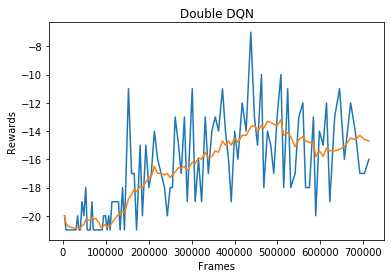

episode 108
t= 0 / Frames 713120 / steps_done 356480 / eps 0.020000017798481234
t= 100 / Frames 713320 / steps_done 356580 / eps 0.020000017709710938
t= 200 / Frames 713520 / steps_done 356680 / eps 0.020000017621383384
t= 300 / Frames 713720 / steps_done 356780 / eps 0.02000001753349637
t= 400 / Frames 713920 / steps_done 356880 / eps 0.02000001744604769
t= 500 / Frames 714120 / steps_done 356980 / eps 0.020000017359035165
t= 600 / Frames 714320 / steps_done 357080 / eps 0.020000017272456615
t= 700 / Frames 714520 / steps_done 357180 / eps 0.02000001718630988
t= 800 / Frames 714720 / steps_done 357280 / eps 0.0200000171005928
t= 900 / Frames 714920 / steps_done 357380 / eps 0.02000001701530324
t= 1000 / Frames 715120 / steps_done 357480 / eps 0.02000001693043906
t= 1100 / Frames 715320 / steps_done 357580 / eps 0.020000016845998142
t= 1200 / Frames 715520 / steps_done 357680 / eps 0.020000016761978375
t= 1300 / Frames 715720 / steps_done 357780 / eps 0.020000016678377662
t= 1400 / Fra

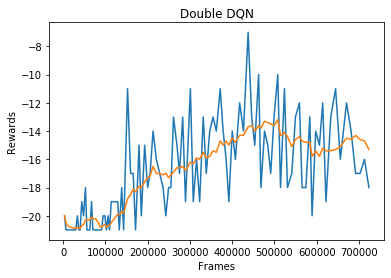

episode 109
t= 0 / Frames 723503 / steps_done 361671 / eps 0.020000013729724167
t= 100 / Frames 723703 / steps_done 361771 / eps 0.02000001366124688
t= 200 / Frames 723903 / steps_done 361871 / eps 0.020000013593111127
t= 300 / Frames 724103 / steps_done 361971 / eps 0.0200000135253152
t= 400 / Frames 724303 / steps_done 362071 / eps 0.020000013457857412
t= 500 / Frames 724503 / steps_done 362171 / eps 0.02000001339073607
t= 600 / Frames 724703 / steps_done 362271 / eps 0.020000013323949493
t= 700 / Frames 724903 / steps_done 362371 / eps 0.020000013257496018
t= 800 / Frames 725103 / steps_done 362471 / eps 0.02000001319137398
t= 900 / Frames 725303 / steps_done 362571 / eps 0.02000001312558173
t= 1000 / Frames 725503 / steps_done 362671 / eps 0.020000013060117616
t= 1100 / Frames 725703 / steps_done 362771 / eps 0.02000001299498001
t= 1200 / Frames 725903 / steps_done 362871 / eps 0.020000012930167274
t= 1300 / Frames 726103 / steps_done 362971 / eps 0.020000012865677798
t= 1400 / Fra

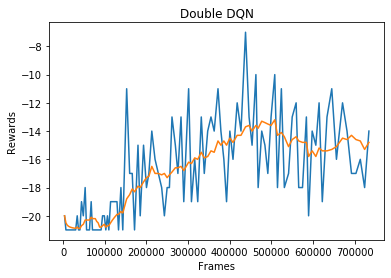

episode 110
t= 0 / Frames 733795 / steps_done 366816 / eps 0.020000010615478053
t= 100 / Frames 733995 / steps_done 366916 / eps 0.020000010562533133
t= 200 / Frames 734195 / steps_done 367016 / eps 0.02000001050985228
t= 300 / Frames 734395 / steps_done 367116 / eps 0.020000010457434172
t= 400 / Frames 734595 / steps_done 367216 / eps 0.020000010405277505
t= 500 / Frames 734795 / steps_done 367316 / eps 0.020000010353380965
t= 600 / Frames 734995 / steps_done 367416 / eps 0.02000001030174326
t= 700 / Frames 735195 / steps_done 367516 / eps 0.020000010250363104
t= 800 / Frames 735395 / steps_done 367616 / eps 0.020000010199239204
t= 900 / Frames 735595 / steps_done 367716 / eps 0.020000010148370287
t= 1000 / Frames 735795 / steps_done 367816 / eps 0.020000010097755077
t= 1100 / Frames 735995 / steps_done 367916 / eps 0.020000010047392314
t= 1200 / Frames 736195 / steps_done 368016 / eps 0.020000009997280736
t= 1300 / Frames 736395 / steps_done 368116 / eps 0.02000000994741909
t= 1400 /

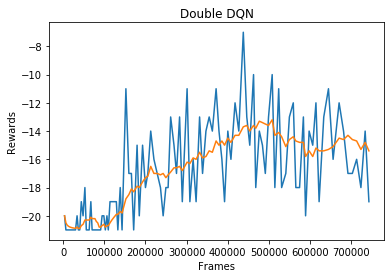

episode 111
t= 0 / Frames 742912 / steps_done 371374 / eps 0.020000008452084772
t= 100 / Frames 743112 / steps_done 371474 / eps 0.020000008409929826
t= 200 / Frames 743312 / steps_done 371574 / eps 0.020000008367985125
t= 300 / Frames 743512 / steps_done 371674 / eps 0.020000008326249624
t= 400 / Frames 743712 / steps_done 371774 / eps 0.02000000828472228
t= 500 / Frames 743912 / steps_done 371874 / eps 0.020000008243402055
t= 600 / Frames 744112 / steps_done 371974 / eps 0.02000000820228792
t= 700 / Frames 744312 / steps_done 372074 / eps 0.020000008161378837
t= 800 / Frames 744512 / steps_done 372174 / eps 0.02000000812067379
t= 900 / Frames 744712 / steps_done 372274 / eps 0.02000000808017176
t= 1000 / Frames 744912 / steps_done 372374 / eps 0.020000008039871734
t= 1100 / Frames 745112 / steps_done 372474 / eps 0.020000007999772706
t= 1200 / Frames 745312 / steps_done 372574 / eps 0.020000007959873674
t= 1300 / Frames 745512 / steps_done 372674 / eps 0.02000000792017364
t= 1400 / F

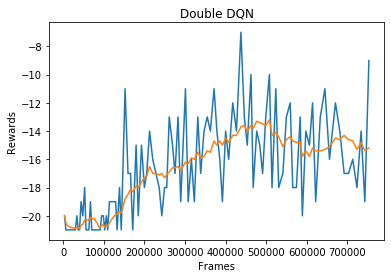

episode 112
t= 0 / Frames 752970 / steps_done 376402 / eps 0.0200000065732812
t= 100 / Frames 753170 / steps_done 376502 / eps 0.020000006540496825
t= 200 / Frames 753370 / steps_done 376602 / eps 0.02000000650787596
t= 300 / Frames 753570 / steps_done 376702 / eps 0.020000006475417793
t= 400 / Frames 753770 / steps_done 376802 / eps 0.020000006443121512
t= 500 / Frames 753970 / steps_done 376902 / eps 0.02000000641098631
t= 600 / Frames 754170 / steps_done 377002 / eps 0.020000006379011382
t= 700 / Frames 754370 / steps_done 377102 / eps 0.020000006347195932
t= 800 / Frames 754570 / steps_done 377202 / eps 0.020000006315539158
t= 900 / Frames 754770 / steps_done 377302 / eps 0.020000006284040275
t= 1000 / Frames 754970 / steps_done 377402 / eps 0.020000006252698495
t= 1100 / Frames 755170 / steps_done 377502 / eps 0.02000000622151303
t= 1200 / Frames 755370 / steps_done 377602 / eps 0.020000006190483106
t= 1300 / Frames 755570 / steps_done 377702 / eps 0.020000006159607942
t= 1400 / F

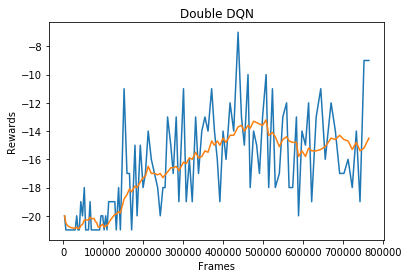

episode 113
t= 0 / Frames 765177 / steps_done 382505 / eps 0.020000004844592478
t= 100 / Frames 765377 / steps_done 382605 / eps 0.020000004820429972
t= 200 / Frames 765577 / steps_done 382705 / eps 0.020000004796387975
t= 300 / Frames 765777 / steps_done 382805 / eps 0.02000000477246589
t= 400 / Frames 765977 / steps_done 382905 / eps 0.02000000474866312
t= 500 / Frames 766177 / steps_done 383005 / eps 0.02000000472497906
t= 600 / Frames 766377 / steps_done 383105 / eps 0.02000000470141313
t= 700 / Frames 766577 / steps_done 383205 / eps 0.020000004677964735
t= 800 / Frames 766777 / steps_done 383305 / eps 0.02000000465463329
t= 900 / Frames 766977 / steps_done 383405 / eps 0.020000004631418208
t= 1000 / Frames 767177 / steps_done 383505 / eps 0.020000004608318914
t= 1100 / Frames 767377 / steps_done 383605 / eps 0.020000004585334828
t= 1200 / Frames 767577 / steps_done 383705 / eps 0.020000004562465375
t= 1300 / Frames 767777 / steps_done 383805 / eps 0.020000004539709983
t= 1400 / F

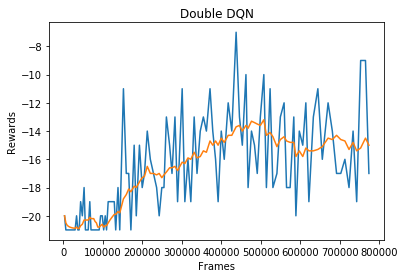

episode 114
t= 0 / Frames 773848 / steps_done 386840 / eps 0.020000003900532685
t= 100 / Frames 774048 / steps_done 386940 / eps 0.0200000038810787
t= 200 / Frames 774248 / steps_done 387040 / eps 0.020000003861721738
t= 300 / Frames 774448 / steps_done 387140 / eps 0.02000000384246132
t= 400 / Frames 774648 / steps_done 387240 / eps 0.020000003823296964
t= 500 / Frames 774848 / steps_done 387340 / eps 0.02000000380422819
t= 600 / Frames 775048 / steps_done 387440 / eps 0.020000003785254523
t= 700 / Frames 775248 / steps_done 387540 / eps 0.020000003766375486
t= 800 / Frames 775448 / steps_done 387640 / eps 0.02000000374759061
t= 900 / Frames 775648 / steps_done 387740 / eps 0.020000003728899426
t= 1000 / Frames 775848 / steps_done 387840 / eps 0.020000003710301462
t= 1100 / Frames 776048 / steps_done 387940 / eps 0.020000003691796255
t= 1200 / Frames 776248 / steps_done 388040 / eps 0.020000003673383344
t= 1300 / Frames 776448 / steps_done 388140 / eps 0.02000000365506227
t= 1400 / Fr

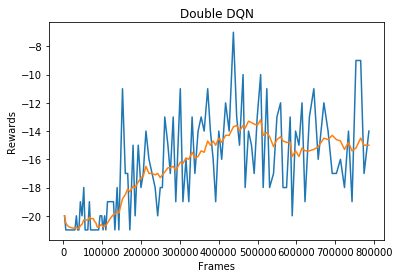

episode 115
t= 0 / Frames 786295 / steps_done 393063 / eps 0.02000000285754576
t= 100 / Frames 786495 / steps_done 393163 / eps 0.020000002843293688
t= 200 / Frames 786695 / steps_done 393263 / eps 0.0200000028291127
t= 300 / Frames 786895 / steps_done 393363 / eps 0.020000002815002443
t= 400 / Frames 787095 / steps_done 393463 / eps 0.02000000280096256
t= 500 / Frames 787295 / steps_done 393563 / eps 0.020000002786992703
t= 600 / Frames 787495 / steps_done 393663 / eps 0.020000002773092516
t= 700 / Frames 787695 / steps_done 393763 / eps 0.02000000275926166
t= 800 / Frames 787895 / steps_done 393863 / eps 0.020000002745499786
t= 900 / Frames 788095 / steps_done 393963 / eps 0.02000000273180655
t= 1000 / Frames 788295 / steps_done 394063 / eps 0.020000002718181607
t= 1100 / Frames 788495 / steps_done 394163 / eps 0.02000000270462462
t= 1200 / Frames 788695 / steps_done 394263 / eps 0.02000000269113525
t= 1300 / Frames 788895 / steps_done 394363 / eps 0.020000002677713156
t= 1400 / Fram

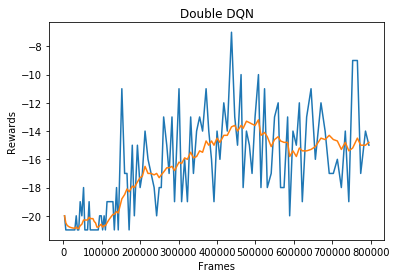

episode 116
t= 0 / Frames 795185 / steps_done 397507 / eps 0.020000002288194617
t= 100 / Frames 795385 / steps_done 397607 / eps 0.020000002276782197
t= 200 / Frames 795585 / steps_done 397707 / eps 0.0200000022654267
t= 300 / Frames 795785 / steps_done 397807 / eps 0.020000002254127836
t= 400 / Frames 795985 / steps_done 397907 / eps 0.02000000224288533
t= 500 / Frames 796185 / steps_done 398007 / eps 0.020000002231698892
t= 600 / Frames 796385 / steps_done 398107 / eps 0.020000002220568247
t= 700 / Frames 796585 / steps_done 398207 / eps 0.020000002209493117
t= 800 / Frames 796785 / steps_done 398307 / eps 0.020000002198473223
t= 900 / Frames 796985 / steps_done 398407 / eps 0.020000002187508293
t= 1000 / Frames 797185 / steps_done 398507 / eps 0.020000002176598048
t= 1100 / Frames 797385 / steps_done 398607 / eps 0.02000000216574222
t= 1200 / Frames 797585 / steps_done 398707 / eps 0.020000002154940535
t= 1300 / Frames 797785 / steps_done 398807 / eps 0.020000002144192727
t= 1400 / 

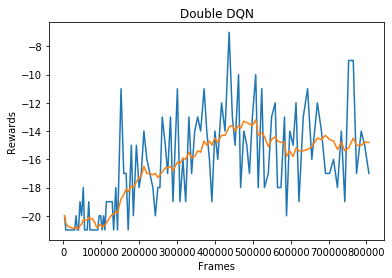

episode 117
t= 0 / Frames 806459 / steps_done 403143 / eps 0.020000001726270204
t= 100 / Frames 806659 / steps_done 403243 / eps 0.020000001717660396
t= 200 / Frames 806859 / steps_done 403343 / eps 0.02000000170909353
t= 300 / Frames 807059 / steps_done 403443 / eps 0.02000000170056939
t= 400 / Frames 807259 / steps_done 403543 / eps 0.020000001692087765
t= 500 / Frames 807459 / steps_done 403643 / eps 0.02000000168364844
t= 600 / Frames 807659 / steps_done 403743 / eps 0.02000000167525121
t= 700 / Frames 807859 / steps_done 403843 / eps 0.020000001666895858
t= 800 / Frames 808059 / steps_done 403943 / eps 0.020000001658582182
t= 900 / Frames 808259 / steps_done 404043 / eps 0.02000000165030997
t= 1000 / Frames 808459 / steps_done 404143 / eps 0.02000000164207901
t= 1100 / Frames 808659 / steps_done 404243 / eps 0.02000000163388911
t= 1200 / Frames 808859 / steps_done 404343 / eps 0.020000001625740053
t= 1300 / Frames 809059 / steps_done 404443 / eps 0.02000000161763164
t= 1400 / Fram

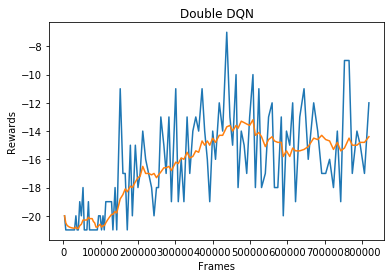

episode 118
t= 0 / Frames 818337 / steps_done 409081 / eps 0.020000001282823015
t= 100 / Frames 818537 / steps_done 409181 / eps 0.020000001276424907
t= 200 / Frames 818737 / steps_done 409281 / eps 0.02000000127005871
t= 300 / Frames 818937 / steps_done 409381 / eps 0.020000001263724268
t= 400 / Frames 819137 / steps_done 409481 / eps 0.020000001257421417
t= 500 / Frames 819337 / steps_done 409581 / eps 0.020000001251150003
t= 600 / Frames 819537 / steps_done 409681 / eps 0.020000001244909867
t= 700 / Frames 819737 / steps_done 409781 / eps 0.02000000123870085
t= 800 / Frames 819937 / steps_done 409881 / eps 0.020000001232522806
t= 900 / Frames 820137 / steps_done 409981 / eps 0.02000000122637557
t= 1000 / Frames 820337 / steps_done 410081 / eps 0.020000001220259
t= 1100 / Frames 820537 / steps_done 410181 / eps 0.020000001214172933
t= 1200 / Frames 820737 / steps_done 410281 / eps 0.020000001208117218
t= 1300 / Frames 820937 / steps_done 410381 / eps 0.020000001202091708
t= 1400 / Fr

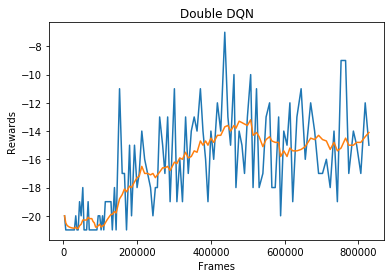

episode 119
t= 0 / Frames 828369 / steps_done 414096 / eps 0.020000000998314553
t= 100 / Frames 828569 / steps_done 414196 / eps 0.02000000099333544
t= 200 / Frames 828769 / steps_done 414296 / eps 0.020000000988381155
t= 300 / Frames 828969 / steps_done 414396 / eps 0.020000000983451584
t= 400 / Frames 829169 / steps_done 414496 / eps 0.0200000009785466
t= 500 / Frames 829369 / steps_done 414596 / eps 0.02000000097366608
t= 600 / Frames 829569 / steps_done 414696 / eps 0.020000000968809897
t= 700 / Frames 829769 / steps_done 414796 / eps 0.02000000096397794
t= 800 / Frames 829969 / steps_done 414896 / eps 0.020000000959170077
t= 900 / Frames 830169 / steps_done 414996 / eps 0.0200000009543862
t= 1000 / Frames 830369 / steps_done 415096 / eps 0.020000000949626177
t= 1100 / Frames 830569 / steps_done 415196 / eps 0.020000000944889896
t= 1200 / Frames 830769 / steps_done 415296 / eps 0.02000000094017724
t= 1300 / Frames 830969 / steps_done 415396 / eps 0.020000000935488083
t= 1400 / Fram

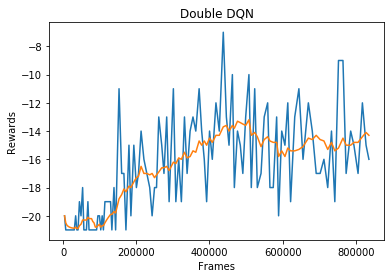

episode 120
t= 0 / Frames 836147 / steps_done 417984 / eps 0.02000000082194083
t= 100 / Frames 836347 / steps_done 418084 / eps 0.020000000817841382
t= 200 / Frames 836547 / steps_done 418184 / eps 0.02000000081376238
t= 300 / Frames 836747 / steps_done 418284 / eps 0.020000000809703725
t= 400 / Frames 836947 / steps_done 418384 / eps 0.02000000080566531
t= 500 / Frames 837147 / steps_done 418484 / eps 0.020000000801647037
t= 600 / Frames 837347 / steps_done 418584 / eps 0.02000000079764881
t= 700 / Frames 837547 / steps_done 418684 / eps 0.02000000079367052
t= 800 / Frames 837747 / steps_done 418784 / eps 0.02000000078971207
t= 900 / Frames 837947 / steps_done 418884 / eps 0.020000000785773363
t= 1000 / Frames 838147 / steps_done 418984 / eps 0.020000000781854304
t= 1100 / Frames 838347 / steps_done 419084 / eps 0.020000000777954788
t= 1200 / Frames 838547 / steps_done 419184 / eps 0.02000000077407472
t= 1300 / Frames 838747 / steps_done 419284 / eps 0.020000000770214008
t= 1400 / Fra

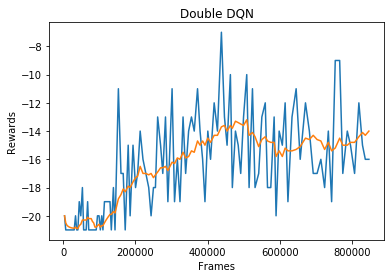

episode 121
t= 0 / Frames 846110 / steps_done 422965 / eps 0.020000000640736572
t= 100 / Frames 846310 / steps_done 423065 / eps 0.020000000637540885
t= 200 / Frames 846510 / steps_done 423165 / eps 0.020000000634361137
t= 300 / Frames 846710 / steps_done 423265 / eps 0.020000000631197248
t= 400 / Frames 846910 / steps_done 423365 / eps 0.020000000628049137
t= 500 / Frames 847110 / steps_done 423465 / eps 0.02000000062491673
t= 600 / Frames 847310 / steps_done 423565 / eps 0.020000000621799945
t= 700 / Frames 847510 / steps_done 423665 / eps 0.020000000618698704
t= 800 / Frames 847710 / steps_done 423765 / eps 0.020000000615612933
t= 900 / Frames 847910 / steps_done 423865 / eps 0.02000000061254255
t= 1000 / Frames 848110 / steps_done 423965 / eps 0.02000000060948748
t= 1100 / Frames 848310 / steps_done 424065 / eps 0.02000000060644765
t= 1200 / Frames 848510 / steps_done 424165 / eps 0.02000000060342298
t= 1300 / Frames 848710 / steps_done 424265 / eps 0.020000000600413397
t= 1400 / F

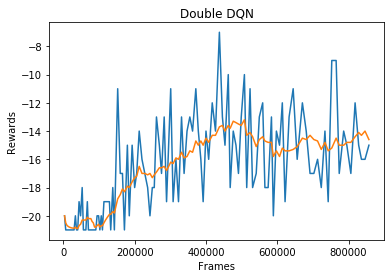

episode 122
t= 0 / Frames 857066 / steps_done 428442 / eps 0.02000000048724565
t= 100 / Frames 857266 / steps_done 428542 / eps 0.0200000004848155
t= 200 / Frames 857466 / steps_done 428642 / eps 0.020000000482397473
t= 300 / Frames 857666 / steps_done 428742 / eps 0.020000000479991505
t= 400 / Frames 857866 / steps_done 428842 / eps 0.02000000047759754
t= 500 / Frames 858066 / steps_done 428942 / eps 0.020000000475215513
t= 600 / Frames 858266 / steps_done 429042 / eps 0.020000000472845364
t= 700 / Frames 858466 / steps_done 429142 / eps 0.02000000047048704
t= 800 / Frames 858666 / steps_done 429242 / eps 0.020000000468140475
t= 900 / Frames 858866 / steps_done 429342 / eps 0.020000000465805613
t= 1000 / Frames 859066 / steps_done 429442 / eps 0.0200000004634824
t= 1100 / Frames 859266 / steps_done 429542 / eps 0.020000000461170772
t= 1200 / Frames 859466 / steps_done 429642 / eps 0.02000000045887067
t= 1300 / Frames 859666 / steps_done 429742 / eps 0.020000000456582043
t= 1400 / Fram

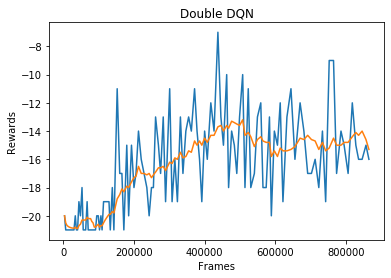

episode 123
t= 0 / Frames 865358 / steps_done 432587 / eps 0.020000000396041266
t= 100 / Frames 865558 / steps_done 432687 / eps 0.020000000394066
t= 200 / Frames 865758 / steps_done 432787 / eps 0.02000000039210059
t= 300 / Frames 865958 / steps_done 432887 / eps 0.02000000039014498
t= 400 / Frames 866158 / steps_done 432987 / eps 0.020000000388199123
t= 500 / Frames 866358 / steps_done 433087 / eps 0.02000000038626297
t= 600 / Frames 866558 / steps_done 433187 / eps 0.020000000384336476
t= 700 / Frames 866758 / steps_done 433287 / eps 0.02000000038241959
t= 800 / Frames 866958 / steps_done 433387 / eps 0.020000000380512264
t= 900 / Frames 867158 / steps_done 433487 / eps 0.020000000378614453
t= 1000 / Frames 867358 / steps_done 433587 / eps 0.020000000376726106
t= 1100 / Frames 867558 / steps_done 433687 / eps 0.020000000374847175
t= 1200 / Frames 867758 / steps_done 433787 / eps 0.020000000372977618
t= 1300 / Frames 867958 / steps_done 433887 / eps 0.020000000371117384
t= 1400 / Fra

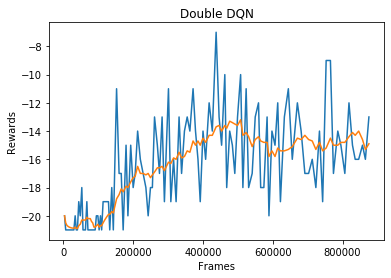

episode 124
t= 0 / Frames 875416 / steps_done 437615 / eps 0.020000000308005736
t= 100 / Frames 875616 / steps_done 437715 / eps 0.02000000030646955
t= 200 / Frames 875816 / steps_done 437815 / eps 0.020000000304941028
t= 300 / Frames 876016 / steps_done 437915 / eps 0.02000000030342013
t= 400 / Frames 876216 / steps_done 438015 / eps 0.020000000301906816
t= 500 / Frames 876416 / steps_done 438115 / eps 0.020000000300401048
t= 600 / Frames 876616 / steps_done 438215 / eps 0.020000000298902792
t= 700 / Frames 876816 / steps_done 438315 / eps 0.02000000029741201
t= 800 / Frames 877016 / steps_done 438415 / eps 0.02000000029592866
t= 900 / Frames 877216 / steps_done 438515 / eps 0.02000000029445271
t= 1000 / Frames 877416 / steps_done 438615 / eps 0.02000000029298412
t= 1100 / Frames 877616 / steps_done 438715 / eps 0.020000000291522855
t= 1200 / Frames 877816 / steps_done 438815 / eps 0.02000000029006888
t= 1300 / Frames 878016 / steps_done 438915 / eps 0.020000000288622154
t= 1400 / Fra

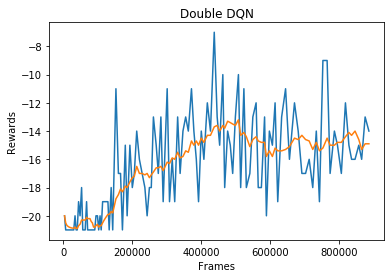

episode 125
t= 0 / Frames 886385 / steps_done 443099 / eps 0.02000000023413981
t= 100 / Frames 886585 / steps_done 443199 / eps 0.02000000023297203
t= 200 / Frames 886785 / steps_done 443299 / eps 0.02000000023181008
t= 300 / Frames 886985 / steps_done 443399 / eps 0.02000000023065392
t= 400 / Frames 887185 / steps_done 443499 / eps 0.02000000022950353
t= 500 / Frames 887385 / steps_done 443599 / eps 0.020000000228358877
t= 600 / Frames 887585 / steps_done 443699 / eps 0.02000000022721993
t= 700 / Frames 887785 / steps_done 443799 / eps 0.020000000226086667
t= 800 / Frames 887985 / steps_done 443899 / eps 0.020000000224959055
t= 900 / Frames 888185 / steps_done 443999 / eps 0.020000000223837067
t= 1000 / Frames 888385 / steps_done 444099 / eps 0.020000000222720676
t= 1100 / Frames 888585 / steps_done 444199 / eps 0.020000000221609852
t= 1200 / Frames 888785 / steps_done 444299 / eps 0.020000000220504566
t= 1300 / Frames 888985 / steps_done 444399 / eps 0.020000000219404797
t= 1400 / Fr

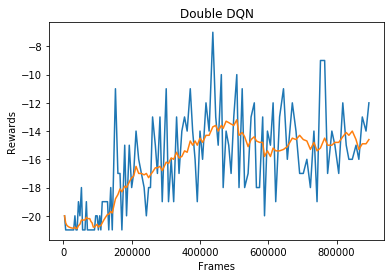

episode 126
t= 0 / Frames 894778 / steps_done 447295 / eps 0.020000000189828
t= 100 / Frames 894978 / steps_done 447395 / eps 0.02000000018888123
t= 200 / Frames 895178 / steps_done 447495 / eps 0.020000000187939182
t= 300 / Frames 895378 / steps_done 447595 / eps 0.02000000018700183
t= 400 / Frames 895578 / steps_done 447695 / eps 0.020000000186069157
t= 500 / Frames 895778 / steps_done 447795 / eps 0.020000000185141132
t= 600 / Frames 895978 / steps_done 447895 / eps 0.020000000184217735
t= 700 / Frames 896178 / steps_done 447995 / eps 0.020000000183298946
t= 800 / Frames 896378 / steps_done 448095 / eps 0.02000000018238474
t= 900 / Frames 896578 / steps_done 448195 / eps 0.020000000181475092
t= 1000 / Frames 896778 / steps_done 448295 / eps 0.020000000180569983
t= 1100 / Frames 896978 / steps_done 448395 / eps 0.020000000179669384
t= 1200 / Frames 897178 / steps_done 448495 / eps 0.02000000017877328
t= 1300 / Frames 897378 / steps_done 448595 / eps 0.020000000177881644
t= 1400 / Fra

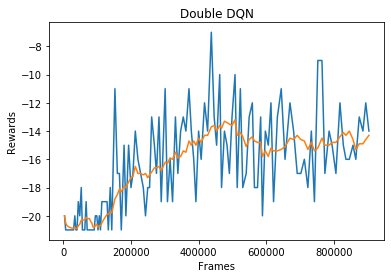

episode 127
t= 0 / Frames 904069 / steps_done 451940 / eps 0.020000000150485753
t= 100 / Frames 904269 / steps_done 452040 / eps 0.0200000001497352
t= 200 / Frames 904469 / steps_done 452140 / eps 0.020000000148988395
t= 300 / Frames 904669 / steps_done 452240 / eps 0.020000000148245312
t= 400 / Frames 904869 / steps_done 452340 / eps 0.020000000147505935
t= 500 / Frames 905069 / steps_done 452440 / eps 0.020000000146770246
t= 600 / Frames 905269 / steps_done 452540 / eps 0.020000000146038227
t= 700 / Frames 905469 / steps_done 452640 / eps 0.02000000014530986
t= 800 / Frames 905669 / steps_done 452740 / eps 0.020000000144585122
t= 900 / Frames 905869 / steps_done 452840 / eps 0.020000000143864
t= 1000 / Frames 906069 / steps_done 452940 / eps 0.020000000143146474
t= 1100 / Frames 906269 / steps_done 453040 / eps 0.020000000142432528
t= 1200 / Frames 906469 / steps_done 453140 / eps 0.020000000141722145
t= 1300 / Frames 906669 / steps_done 453240 / eps 0.020000000141015304
t= 1400 / Fr

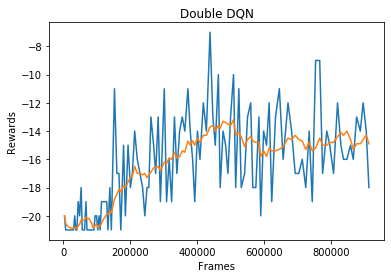

episode 128
t= 0 / Frames 911973 / steps_done 455891 / eps 0.02000000012350954
t= 100 / Frames 912173 / steps_done 455991 / eps 0.020000000122893536
t= 200 / Frames 912373 / steps_done 456091 / eps 0.020000000122280603
t= 300 / Frames 912573 / steps_done 456191 / eps 0.020000000121670723
t= 400 / Frames 912773 / steps_done 456291 / eps 0.02000000012106389
t= 500 / Frames 912973 / steps_done 456391 / eps 0.02000000012046008
t= 600 / Frames 913173 / steps_done 456491 / eps 0.020000000119859283
t= 700 / Frames 913373 / steps_done 456591 / eps 0.020000000119261483
t= 800 / Frames 913573 / steps_done 456691 / eps 0.020000000118666664
t= 900 / Frames 913773 / steps_done 456791 / eps 0.02000000011807481
t= 1000 / Frames 913973 / steps_done 456891 / eps 0.02000000011748591
t= 1100 / Frames 914173 / steps_done 456991 / eps 0.020000000116899945
t= 1200 / Frames 914373 / steps_done 457091 / eps 0.020000000116316904
t= 1300 / Frames 914573 / steps_done 457191 / eps 0.02000000011573677
t= 1400 / Fr

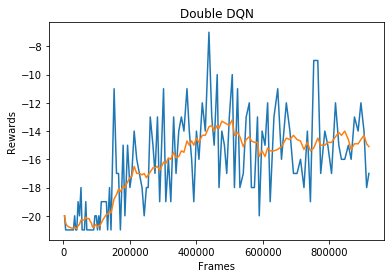

episode 129
t= 0 / Frames 918809 / steps_done 459308 / eps 0.020000000104112122
t= 100 / Frames 919009 / steps_done 459408 / eps 0.02000000010359286
t= 200 / Frames 919209 / steps_done 459508 / eps 0.02000000010307619
t= 300 / Frames 919409 / steps_done 459608 / eps 0.020000000102562095
t= 400 / Frames 919609 / steps_done 459708 / eps 0.020000000102050563
t= 500 / Frames 919809 / steps_done 459808 / eps 0.020000000101541585
t= 600 / Frames 920009 / steps_done 459908 / eps 0.020000000101035142
t= 700 / Frames 920209 / steps_done 460008 / eps 0.02000000010053123
t= 800 / Frames 920409 / steps_done 460108 / eps 0.02000000010002983
t= 900 / Frames 920609 / steps_done 460208 / eps 0.020000000099530926
t= 1000 / Frames 920809 / steps_done 460308 / eps 0.020000000099034514
t= 1100 / Frames 921009 / steps_done 460408 / eps 0.020000000098540575
t= 1200 / Frames 921209 / steps_done 460508 / eps 0.020000000098049104
t= 1300 / Frames 921409 / steps_done 460608 / eps 0.020000000097560082
t= 1400 / 

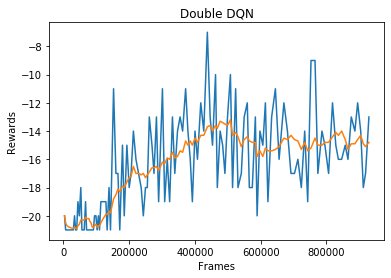

episode 130
t= 0 / Frames 928995 / steps_done 464400 / eps 0.020000000080710477
t= 100 / Frames 929195 / steps_done 464500 / eps 0.020000000080307934
t= 200 / Frames 929395 / steps_done 464600 / eps 0.020000000079907397
t= 300 / Frames 929595 / steps_done 464700 / eps 0.020000000079508855
t= 400 / Frames 929795 / steps_done 464800 / eps 0.020000000079112304
t= 500 / Frames 929995 / steps_done 464900 / eps 0.02000000007871773
t= 600 / Frames 930195 / steps_done 465000 / eps 0.020000000078325125
t= 700 / Frames 930395 / steps_done 465100 / eps 0.020000000077934475
t= 800 / Frames 930595 / steps_done 465200 / eps 0.020000000077545776
t= 900 / Frames 930795 / steps_done 465300 / eps 0.020000000077159016
t= 1000 / Frames 930995 / steps_done 465400 / eps 0.02000000007677418
t= 1100 / Frames 931195 / steps_done 465500 / eps 0.02000000007639127
t= 1200 / Frames 931395 / steps_done 465600 / eps 0.020000000076010268
t= 1300 / Frames 931595 / steps_done 465700 / eps 0.020000000075631165
t= 1400 /

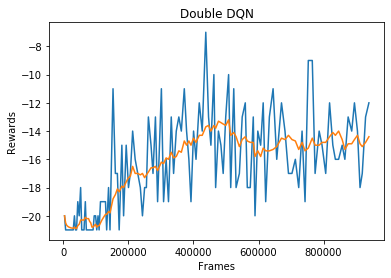

episode 131
t= 0 / Frames 939246 / steps_done 469525 / eps 0.020000000062465752
t= 100 / Frames 939446 / steps_done 469625 / eps 0.020000000062154202
t= 200 / Frames 939646 / steps_done 469725 / eps 0.020000000061844207
t= 300 / Frames 939846 / steps_done 469825 / eps 0.020000000061535756
t= 400 / Frames 940046 / steps_done 469925 / eps 0.020000000061228845
t= 500 / Frames 940246 / steps_done 470025 / eps 0.020000000060923465
t= 600 / Frames 940446 / steps_done 470125 / eps 0.020000000060619607
t= 700 / Frames 940646 / steps_done 470225 / eps 0.020000000060317265
t= 800 / Frames 940846 / steps_done 470325 / eps 0.020000000060016433
t= 900 / Frames 941046 / steps_done 470425 / eps 0.0200000000597171
t= 1000 / Frames 941246 / steps_done 470525 / eps 0.02000000005941926
t= 1100 / Frames 941446 / steps_done 470625 / eps 0.020000000059122905
t= 1200 / Frames 941646 / steps_done 470725 / eps 0.02000000005882803
t= 1300 / Frames 941846 / steps_done 470825 / eps 0.020000000058534622
t= 1400 / 

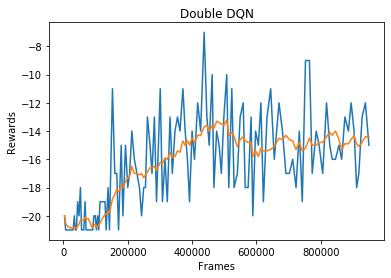

episode 132
t= 0 / Frames 950142 / steps_done 474972 / eps 0.020000000047573144
t= 100 / Frames 950342 / steps_done 475072 / eps 0.020000000047335872
t= 200 / Frames 950542 / steps_done 475172 / eps 0.020000000047099783
t= 300 / Frames 950742 / steps_done 475272 / eps 0.020000000046864874
t= 400 / Frames 950942 / steps_done 475372 / eps 0.020000000046631133
t= 500 / Frames 951142 / steps_done 475472 / eps 0.02000000004639856
t= 600 / Frames 951342 / steps_done 475572 / eps 0.020000000046167147
t= 700 / Frames 951542 / steps_done 475672 / eps 0.020000000045936887
t= 800 / Frames 951742 / steps_done 475772 / eps 0.020000000045707775
t= 900 / Frames 951942 / steps_done 475872 / eps 0.020000000045479808
t= 1000 / Frames 952142 / steps_done 475972 / eps 0.020000000045252975
t= 1100 / Frames 952342 / steps_done 476072 / eps 0.020000000045027274
t= 1200 / Frames 952542 / steps_done 476172 / eps 0.0200000000448027
t= 1300 / Frames 952742 / steps_done 476272 / eps 0.020000000044579247
t= 1400 /

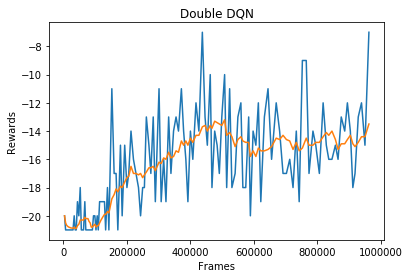

episode 133
t= 0 / Frames 962574 / steps_done 481187 / eps 0.020000000034866218
t= 100 / Frames 962774 / steps_done 481287 / eps 0.020000000034692322
t= 200 / Frames 962974 / steps_done 481387 / eps 0.020000000034519294
t= 300 / Frames 963174 / steps_done 481487 / eps 0.02000000003434713
t= 400 / Frames 963374 / steps_done 481587 / eps 0.020000000034175822
t= 500 / Frames 963574 / steps_done 481687 / eps 0.02000000003400537
t= 600 / Frames 963774 / steps_done 481787 / eps 0.020000000033835768
t= 700 / Frames 963974 / steps_done 481887 / eps 0.02000000003366701
t= 800 / Frames 964174 / steps_done 481987 / eps 0.020000000033499096
t= 900 / Frames 964374 / steps_done 482087 / eps 0.020000000033332018
t= 1000 / Frames 964574 / steps_done 482187 / eps 0.020000000033165773
t= 1100 / Frames 964774 / steps_done 482287 / eps 0.02000000003300036
t= 1200 / Frames 964974 / steps_done 482387 / eps 0.02000000003283577
t= 1300 / Frames 965174 / steps_done 482487 / eps 0.020000000032672
t= 1400 / Fram

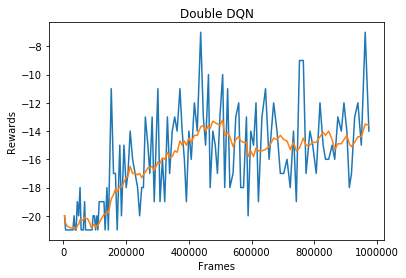

episode 134
t= 0 / Frames 974398 / steps_done 487098 / eps 0.02000000002594473
t= 100 / Frames 974598 / steps_done 487198 / eps 0.02000000002581533
t= 200 / Frames 974798 / steps_done 487298 / eps 0.020000000025686575
t= 300 / Frames 974998 / steps_done 487398 / eps 0.020000000025558462
t= 400 / Frames 975198 / steps_done 487498 / eps 0.020000000025430988
t= 500 / Frames 975398 / steps_done 487598 / eps 0.02000000002530415
t= 600 / Frames 975598 / steps_done 487698 / eps 0.020000000025177947
t= 700 / Frames 975798 / steps_done 487798 / eps 0.02000000002505237
t= 800 / Frames 975998 / steps_done 487898 / eps 0.02000000002492742
t= 900 / Frames 976198 / steps_done 487998 / eps 0.020000000024803094
t= 1000 / Frames 976398 / steps_done 488098 / eps 0.020000000024679387
t= 1100 / Frames 976598 / steps_done 488198 / eps 0.0200000000245563
t= 1200 / Frames 976798 / steps_done 488298 / eps 0.020000000024433823
t= 1300 / Frames 976998 / steps_done 488398 / eps 0.02000000002431196
t= 1400 / Fram

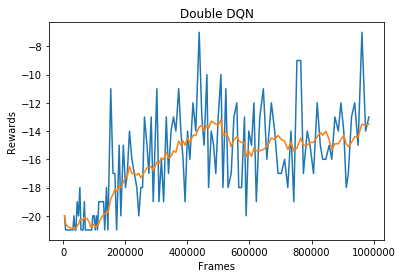

episode 135
t= 0 / Frames 985077 / steps_done 492437 / eps 0.02000000001986617
t= 100 / Frames 985277 / steps_done 492537 / eps 0.02000000001976709
t= 200 / Frames 985477 / steps_done 492637 / eps 0.0200000000196685
t= 300 / Frames 985677 / steps_done 492737 / eps 0.020000000019570405
t= 400 / Frames 985877 / steps_done 492837 / eps 0.020000000019472795
t= 500 / Frames 986077 / steps_done 492937 / eps 0.020000000019375675
t= 600 / Frames 986277 / steps_done 493037 / eps 0.020000000019279037
t= 700 / Frames 986477 / steps_done 493137 / eps 0.020000000019182885
t= 800 / Frames 986677 / steps_done 493237 / eps 0.020000000019087208
t= 900 / Frames 986877 / steps_done 493337 / eps 0.02000000001899201
t= 1000 / Frames 987077 / steps_done 493437 / eps 0.020000000018897287
t= 1100 / Frames 987277 / steps_done 493537 / eps 0.020000000018803036
t= 1200 / Frames 987477 / steps_done 493637 / eps 0.020000000018709257
t= 1300 / Frames 987677 / steps_done 493737 / eps 0.020000000018615943
t= 1400 / F

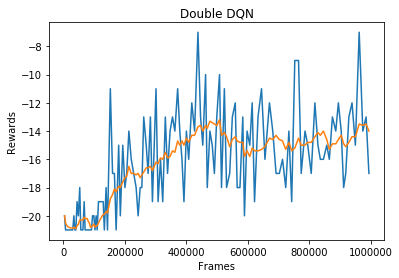

episode 136
t= 0 / Frames 994191 / steps_done 496993 / eps 0.020000000015819107
t= 100 / Frames 994391 / steps_done 497093 / eps 0.020000000015740208
t= 200 / Frames 994591 / steps_done 497193 / eps 0.0200000000156617
t= 300 / Frames 994791 / steps_done 497293 / eps 0.02000000001558359
t= 400 / Frames 994991 / steps_done 497393 / eps 0.020000000015505868
t= 500 / Frames 995191 / steps_done 497493 / eps 0.02000000001542853
t= 600 / Frames 995391 / steps_done 497593 / eps 0.02000000001535158
t= 700 / Frames 995591 / steps_done 497693 / eps 0.020000000015275014
t= 800 / Frames 995791 / steps_done 497793 / eps 0.02000000001519883
t= 900 / Frames 995991 / steps_done 497893 / eps 0.020000000015123025
t= 1000 / Frames 996191 / steps_done 497993 / eps 0.0200000000150476
t= 1100 / Frames 996391 / steps_done 498093 / eps 0.020000000014972548
t= 1200 / Frames 996591 / steps_done 498193 / eps 0.02000000001489787
t= 1300 / Frames 996791 / steps_done 498293 / eps 0.02000000001482357
t= 1400 / Frames

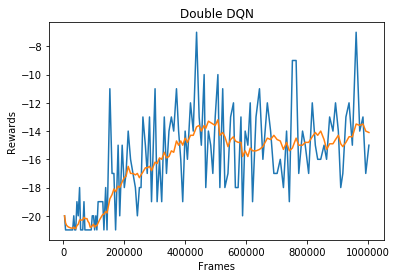

episode 137
t= 0 / Frames 1004587 / steps_done 502190 / eps 0.020000000012199176
t= 100 / Frames 1004787 / steps_done 502290 / eps 0.020000000012138332
t= 200 / Frames 1004987 / steps_done 502390 / eps 0.020000000012077794
t= 300 / Frames 1005187 / steps_done 502490 / eps 0.020000000012017554
t= 400 / Frames 1005387 / steps_done 502590 / eps 0.020000000011957616
t= 500 / Frames 1005587 / steps_done 502690 / eps 0.020000000011897976
t= 600 / Frames 1005787 / steps_done 502790 / eps 0.020000000011838635
t= 700 / Frames 1005987 / steps_done 502890 / eps 0.02000000001177959
t= 800 / Frames 1006187 / steps_done 502990 / eps 0.02000000001172084
t= 900 / Frames 1006387 / steps_done 503090 / eps 0.020000000011662383
t= 1000 / Frames 1006587 / steps_done 503190 / eps 0.020000000011604215
t= 1100 / Frames 1006787 / steps_done 503290 / eps 0.02000000001154634
t= 1200 / Frames 1006987 / steps_done 503390 / eps 0.02000000001148875
t= 1300 / Frames 1007187 / steps_done 503490 / eps 0.020000000011431

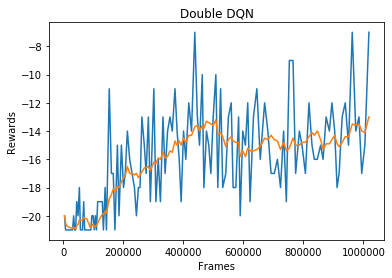

episode 138
t= 0 / Frames 1018107 / steps_done 508949 / eps 0.02000000000870083
t= 100 / Frames 1018307 / steps_done 509049 / eps 0.020000000008657436
t= 200 / Frames 1018507 / steps_done 509149 / eps 0.020000000008614256
t= 300 / Frames 1018707 / steps_done 509249 / eps 0.020000000008571293
t= 400 / Frames 1018907 / steps_done 509349 / eps 0.020000000008528543
t= 500 / Frames 1019107 / steps_done 509449 / eps 0.020000000008486007
t= 600 / Frames 1019307 / steps_done 509549 / eps 0.02000000000844368
t= 700 / Frames 1019507 / steps_done 509649 / eps 0.020000000008401568
t= 800 / Frames 1019707 / steps_done 509749 / eps 0.020000000008359668
t= 900 / Frames 1019907 / steps_done 509849 / eps 0.02000000000831797
t= 1000 / Frames 1020107 / steps_done 509949 / eps 0.020000000008276484
t= 1100 / Frames 1020307 / steps_done 510049 / eps 0.020000000008235208
t= 1200 / Frames 1020507 / steps_done 510149 / eps 0.020000000008194133
t= 1300 / Frames 1020707 / steps_done 510249 / eps 0.02000000000815

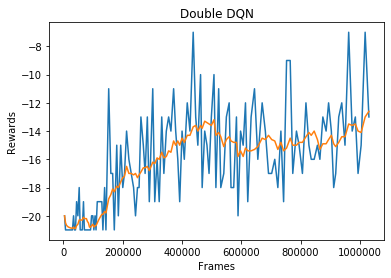

episode 139
t= 0 / Frames 1030823 / steps_done 515306 / eps 0.0200000000063317
t= 100 / Frames 1031023 / steps_done 515406 / eps 0.020000000006300117
t= 200 / Frames 1031223 / steps_done 515506 / eps 0.020000000006268698
t= 300 / Frames 1031423 / steps_done 515606 / eps 0.02000000000623743
t= 400 / Frames 1031623 / steps_done 515706 / eps 0.02000000000620632
t= 500 / Frames 1031823 / steps_done 515806 / eps 0.02000000000617537
t= 600 / Frames 1032023 / steps_done 515906 / eps 0.020000000006144568
t= 700 / Frames 1032223 / steps_done 516006 / eps 0.020000000006113922
t= 800 / Frames 1032423 / steps_done 516106 / eps 0.02000000000608343
t= 900 / Frames 1032623 / steps_done 516206 / eps 0.02000000000605309
t= 1000 / Frames 1032823 / steps_done 516306 / eps 0.020000000006022898
t= 1100 / Frames 1033023 / steps_done 516406 / eps 0.02000000000599286
t= 1200 / Frames 1033223 / steps_done 516506 / eps 0.02000000000596297
t= 1300 / Frames 1033423 / steps_done 516606 / eps 0.02000000000593323
t=

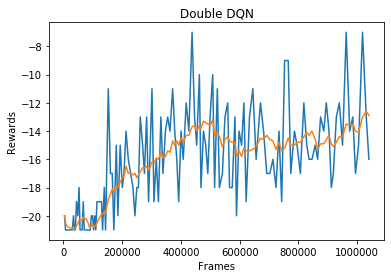

Complete
GPU pickle complete
CPU pickle complete


In [0]:
train(40)# training
# save the trained model
with open('data.pickle', 'wb') as f:
  pickle.dump((policy_net.state_dict(),target_net.state_dict(),T,frames,durations,R,steps_done,difficulty,STEPS),f)
print("pickle complete")

# Plot rewards and episode durations

In [3]:
plt.figure()
plt.plot(frames,episode_durations)
plt.plot(movave(episode_durations,15))
plt.xlabel('frames')
plt.ylabel('durations')
plt.show()
plt.figure()
plt.plot(frames,R)
plt.plot(frames,movave(R,15))
plt.xlabel('frames')
plt.ylabel('rewards')
plt.show()

NameError: name 'episode_durations' is not defined

<Figure size 432x288 with 0 Axes>

# Play the game where the agent is trained.

In [4]:
def play(env):
    env = wrappers.Monitor(env, "./gym-results", force=True)  # Create wrapper to display environment
    env.reset()
    s = [i for i in range(num_scr)]
    a = [i for i in range(num_scr-1)]
    d = [False for i in range(num_scr-1)]
    for i in range(num_scr-1):
        s[i]=get_screen()
        a[i]=torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)
        _,_,d[i],_=env.step(a[i].item())
    s[num_scr-1]=get_screen()
    state = torch.cat([s[i].squeeze(0) for i in range(num_scr)]).unsqueeze(0)
    if sum(d)!=0:
        env.close()
        print('Initial state failed')
        return
    else:
        R = 0
        for _ in range(10000):
            env.render()
            action = policy_net(state).max(1)[1].view(1, 1)
            ss=[i for i in range(num_scr)]
            dd=[False for i in range(num_scr)]
            for i in range(num_scr):
                _, reward, dd[i], _ = env.step(action.item())
                env.render()
                R = R+reward
                ss[i]=get_screen()
            state = torch.cat([ss[i].squeeze(0) for i in range(num_scr)]).unsqueeze(0)
            if sum(dd)!=0:
                break
        env.close()

# Plot results including the results shown in the report. 

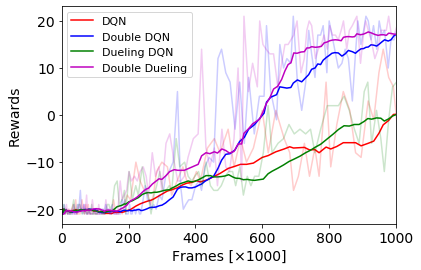

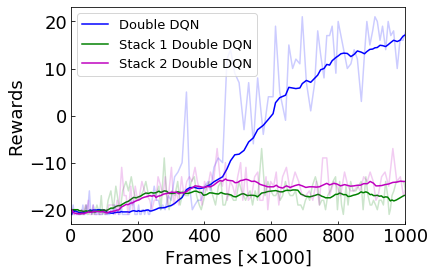

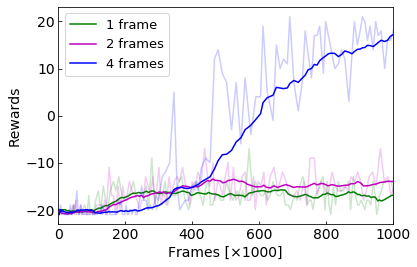

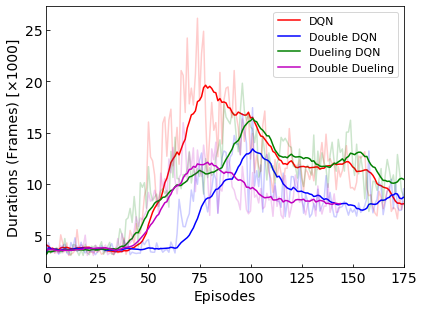

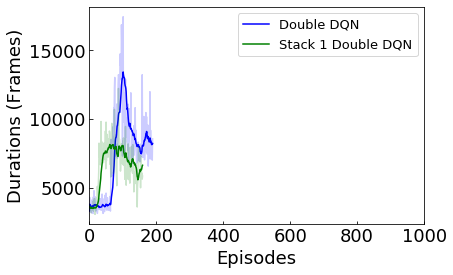

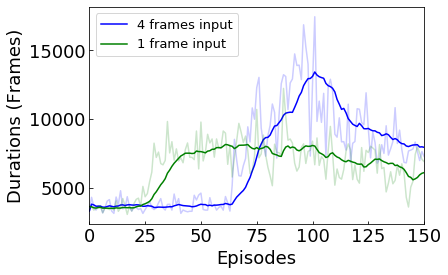

NameError: name 't' is not defined

In [7]:
import pickle
import matplotlib.pyplot as plt
file=['Dec1/Dec1cpu','Dec1/Dec1cpu_double','Dec1/Dec1cpu_duel',
      'Dec1/Dec1cpu_doubleduel','Dec2/Dec2cpu_cat1',
      'Dec2/Dec2cpu_doubleduel_huber',
      'Dec2/Dec2cpudddww','Dec2/Dec2cpu_double_cat1',
      'Dec2/Dec2cpu_double_cat2','Dec2/Dec2cpuv0','Dec2/Dec2cpuv0_double']
P=len(file)
policy=[True for i in range(P)];target=[True for i in range(P)];dur=[True for i in range(P)]
T=[True for i in range(P)];frames=[True for i in range(P)];R=[True for i in range(P)];
steps_done=[True for i in range(P)];
for i in range(P):
    with open(file[i]+'.pickle', 'rb') as f:
        policy[i],target[i],T[i],frames[i],dur[i],R[i],steps_done[i],_,_=pickle.load(f)
    
col=['r-','b-','g-','m-','k-','r-','b-','g-','m-']
dqname={0:'DQN',1:'Double DQN',2:'Dueling DQN',3:'Double Dueling',
        4:'Stack 1 DQN',5:'Huber Double Dueling',6:'MSE Double Dueling',
        7:'Stack 1 Double DQN',8:'Stack 2 Double DQN',9:'v0 DQN',10:'v0 Double'}
# moving average for plotting
def movave(r,n=10):
    X=[i for i in range(len(r))]
    for i in range(len(r)):
        if i+1<n:
            X[i]=sum(r[:i+1])/(i+1)
        else:
            X[i]=sum(r[i+1-n:i+1])/n
    return X

# plots
plt.figure()
for i in range(4):
    plt.plot(np.array(frames[i])/10**3,movave(R[i],15),col[i],label=dqname[i])
    plt.plot(np.array(frames[i])/10**3,R[i],col[i],alpha=0.2)
plt.xlabel('Frames [×1000]',fontsize=14);
plt.ylabel('Rewards',fontsize=14);
plt.tick_params(labelsize=14);
plt.xlim([0,1000]);
plt.legend(fontsize=11);
#plt.title('Double DQN, Dueling DQN',fontsize=15)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.savefig('Difmodelpdf.pdf');plt.show()

plt.figure()
for i in [1,7,8]:
    plt.plot(np.array(frames[i])/10**3,movave(R[i],15),col[i],label=dqname[i])
    plt.plot(np.array(frames[i])/10**3,R[i],col[i],alpha=0.2)
plt.xlabel('Frames [×1000]',fontsize=18);plt.ylabel('Rewards',fontsize=18);
plt.tick_params(labelsize=18);plt.xlim([0,1000]);plt.legend(fontsize=13);
#plt.title('Loss MSE vs Huber')
plt.savefig('loss_comp.pdf');plt.show()

plt.figure()
plt.plot(np.array(frames[7])/10**3,movave(R[7],15),col[7],label='1 frame')
plt.plot(np.array(frames[7])/10**3,R[7],col[7],alpha=0.2)
plt.plot(np.array(frames[8])/10**3,movave(R[8],15),col[8],label='2 frames')
plt.plot(np.array(frames[8])/10**3,R[8],col[8],alpha=0.2)
plt.plot(np.array(frames[1])/10**3,movave(R[1],15),col[1],label='4 frames')
plt.plot(np.array(frames[1])/10**3,R[1],col[1],alpha=0.2)
plt.xlabel('Frames [×1000]',fontsize=14);plt.ylabel('Rewards',fontsize=14);
plt.tick_params(labelsize=14);plt.xlim([0,1000]);plt.legend(fontsize=13);
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
#plt.title('Stack DQN')
plt.savefig('catpdf.pdf');plt.show()

# =============================================================================
# Durations
# =============================================================================

# plots
plt.figure(figsize=(6.4, 4.8))
for i in range(4):
    plt.plot(movave(np.array(dur[i])/10**3,15),col[i],label=dqname[i])
    plt.plot(np.array(dur[i])/10**3,col[i],alpha=0.2)
plt.xlabel('Episodes',fontsize=14);
plt.ylabel('Durations (Frames) [×1000]',fontsize=14);
plt.tick_params(labelsize=14);
plt.xlim([0,175]);
plt.legend(fontsize=11);
#plt.title('Episode durations',fontsize=20)
plt.savefig('dur.pdf');plt.show()

plt.figure()
for i in [1,7]:
    plt.plot(movave(dur[i],15),col[i],label=dqname[i])
    plt.plot(dur[i],col[i],alpha=0.2)
plt.xlabel('Episodes',fontsize=18);plt.ylabel('Durations (Frames)',fontsize=18);
plt.tick_params(labelsize=18);plt.xlim([0,1000]);plt.legend(fontsize=13);
#plt.title('Loss MSE vs Huber')
plt.savefig('loss_comp_dur.pdf');plt.show()

plt.figure()
plt.plot(movave(dur[1],15),col[1],label='4 frames input')
plt.plot(dur[1],col[1],alpha=0.2)
plt.plot(movave(dur[7],15),col[7],label='1 frame input')
plt.plot(dur[7],col[7],alpha=0.2)
plt.xlabel('Episodes',fontsize=18);plt.ylabel('Durations (Frames)',fontsize=18);
plt.tick_params(labelsize=18);plt.xlim([0,150]);plt.legend(fontsize=13);
#plt.title('Stack DQN')
plt.savefig('cat_dur.pdf');plt.show()

# =============================================================================
# =============================================================================
# steps epsilon
# =============================================================================
# =============================================================================

def eps(step):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * step / EPS_DECAY)
    return eps_threshold

from itertools import count
num_scr=4
steps=0
E=[]
for i in range(len(durations)):
    t=0
for k in range(num_scr-1):
    t+=1
    E.append(eps(steps))
    for m in count():
        for n in range(num_scr):
            E.append(eps(steps))      
    steps+=1
    t+=1
    if t==durations[i]:break

plt.figure()
plt.plot(E)
plt.xscale('linear')
plt.tick_params(labelsize=18)
plt.xlim(0,len(E))
plt.xlabel('Steps',fontsize=18);plt.ylabel('Epsilon',fontsize=18);
plt.savefig('epsilon.png')
plt.show()